# Correlations
This notebook displays the correlation between viral barcode expression in the transcriptome, supernatant, and second infection.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy as np

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
# Hardcoded for now
expt = 'scProgenyProduction_trial2'
viral_tag_by_cell_csv = f'results/viral_tags_bcs_in_cells/{expt}_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_filtered_csv = f'results/viral_fastq10x/{expt}_viral_bc_by_cell_filtered.csv.gz'
viral_bc_in_progeny_freq_csv = f'results/viral_progeny/{expt}_viral_bc_in_progeny_corrected.csv.gz'
plot = f'results/viral_fastq10x/{expt}_viral_bc_correlations.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

In [3]:
p9.theme_set(p9.theme_classic())

## Organize data
Read the cell barcodes and tags into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAAGTAGGTTA,True,syn
1,AAACCCACAAGGCCTC,True,syn
2,AAACCCACACACACGC,True,both
3,AAACCCATCGTGCATA,True,syn
4,AAACCCATCTACTGCC,False,none
...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none
7437,TTTGGTTTCGTCGCTT,False,none
7438,TTTGTTGCATGTGGTT,True,wt
7439,TTTGTTGTCGTCGGGT,False,none


Read the viral barcode frequencies from the transcriptome. Filter out viral barcodes that didn't pass significant threshold.

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_by_cell_filtered_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
transcriptome_viral_bc_freqs = (transcriptome_viral_bc_freqs
                                .query('reject_uninfected == True'))
transcriptome_viral_bc_freqs = transcriptome_viral_bc_freqs.drop(columns = 'reject_uninfected')
display(transcriptome_viral_bc_freqs)

,cell_barcode,gene,viral_barcode,frac_viral_bc_UMIs
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,0.002609
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,0.002236
6,AAACCCAAGTAGGTTA,fluHA,CTTAACTGTATATTCG,0.004844
8,AAACCCAAGTAGGTTA,fluHA,TCTTAAGTATATCAGA,0.002422
12,AAACCCAAGTAGGTTA,fluHA,TGTAAATAGAGTTCGC,0.003726
...,...,...,...,...
58905,TTTGGTTCATCTGCGG,fluNA,TTGTATAAAAATACAG,0.007323
58906,TTTGGTTGTCGGTGTC,fluNA,AATAAGCGGCTCTTTG,0.003318
58913,TTTGTTGCATGTGGTT,fluNA,CACCCCGTTAGTGGGG,0.007294
58923,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,0.009800


Read the viral barcode frequencies from the progeny. **For now just work with supernatant data. Remove second_infection frequencies.**

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'corrected_bc': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'freq': 'freq_progeny'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny
72052,syn,fluHA,AAAAAAATCTTAATGA,0.000243
72053,syn,fluHA,AAAAAACGAATAAATT,0.000002
72054,syn,fluHA,AAAAAACGAATGGATT,0.000336
72055,syn,fluHA,AAAAAACGAGAAGAAT,0.000001
72056,syn,fluHA,AAAAAAGTTGAGATTT,0.000001
...,...,...,...,...
97959,wt,fluNA,TTTTGATGGTAAGTAC,0.000223
97960,wt,fluNA,TTTTGCTTCGAGATAG,0.001143
97961,wt,fluNA,TTTTGTCATGATAGCC,0.000185
97962,wt,fluNA,TTTTGTTAGCGTCCTG,0.000308


Add tag sharing info. This is the tags the viral barcode is found in in the supernatant sequencing.

In [7]:
tag_data = pd.read_csv(f'results/viral_progeny/{expt}_viral_bc_tags.csv')
progeny_viral_bc_freqs = pd.merge(
    left=progeny_viral_bc_freqs,
    right=tag_data,
    how='outer',
    on=['gene', 'viral_barcode'])

display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny,present_in_supernatant_tags
0,syn,fluHA,AAAAAAATCTTAATGA,0.000243,syn
1,syn,fluHA,AAAAAACGAATAAATT,0.000002,syn
2,syn,fluHA,AAAAAACGAATGGATT,0.000336,syn
3,syn,fluHA,AAAAAACGAGAAGAAT,0.000001,syn
4,syn,fluHA,AAAAAAGTTGAGATTT,0.000001,syn
...,...,...,...,...,...
39914,NaN,fluNA,TTTTTCTCGGATGGAA,NaN,syn
39915,NaN,fluNA,TTTTTGTTGGGGCAAG,NaN,syn
39916,NaN,fluNA,TTTTTTAGAAAACGTA,NaN,wt
39917,NaN,fluNA,TTTTTTCACTGCCATT,NaN,wt


Merge dataframes to one. This will be done in two steps. First, merge transcriptome frequencies with all cells tag info.  Then, merge supernatant frequencies into this dataframe.

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene.
5. Viral barcode
6. Frequency in transcriptome (`frac_viral_bc_UMIs`)
7. Frequency in supernatant sequencing (`freq_progeny`)

In [8]:
viral_bc_freqs = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=transcriptome_viral_bc_freqs,
    how='outer',
    on=['cell_barcode', 'gene'],
    validate='one_to_many')
assert (viral_bc_freqs['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_freqs['viral_barcode'].nunique() ==
        transcriptome_viral_bc_freqs['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe don't " \
       "match number of barcodes in source data."

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])
# Need to think of what asserts to include here

display(viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,freq_progeny,present_in_supernatant_tags
0,AAACCCAAGTAGGTTA,True,syn,fluHA,AGAATCGACACATGTC,0.002609,NaN,NaN
1,GTAGGTTTCGTTTACT,True,syn,fluHA,AGAATCGACACATGTC,0.002756,NaN,NaN
2,AAACCCAAGTAGGTTA,True,syn,fluHA,CACGGATGGTGTACGA,0.002236,NaN,NaN
3,AAACCCAAGTAGGTTA,True,syn,fluHA,CTTAACTGTATATTCG,0.004844,0.000981,syn and wt
4,AAAGTCCAGGATTTAG,True,syn,fluHA,CTTAACTGTATATTCG,0.003273,0.000981,syn and wt
...,...,...,...,...,...,...,...,...
59132,NaN,NaN,NaN,fluNA,TTTTTCTCGGATGGAA,NaN,NaN,syn
59133,NaN,NaN,NaN,fluNA,TTTTTGTTGGGGCAAG,NaN,NaN,syn
59134,NaN,NaN,NaN,fluNA,TTTTTTAGAAAACGTA,NaN,NaN,wt
59135,NaN,NaN,NaN,fluNA,TTTTTTCACTGCCATT,NaN,NaN,wt


Only keep barcodes found in the transcriptome data, since these are the ones we can study.

In [9]:
viral_bc_freqs = viral_bc_freqs.query('frac_viral_bc_UMIs.notnull()', engine='python')
viral_bc_freqs.describe()

,frac_viral_bc_UMIs,freq_progeny
count,16305.000000,6.279000e+03
mean,0.010821,8.097163e-04
std,0.040305,3.633623e-03
min,0.000559,8.987181e-07
25%,0.002268,1.109113e-04
50%,0.003490,1.824398e-04
75%,0.006295,3.456483e-04
max,0.683152,3.381952e-02


Only look at infected cells in dataset.

In [18]:
viral_bc_freqs = viral_bc_freqs.query('infected == True')
viral_bc_freqs.describe()
viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,freq_progeny,present_in_supernatant_tags
0,AAACCCAAGTAGGTTA,True,syn,fluHA,AGAATCGACACATGTC,0.002609,NaN,NaN
1,GTAGGTTTCGTTTACT,True,syn,fluHA,AGAATCGACACATGTC,0.002756,NaN,NaN
2,AAACCCAAGTAGGTTA,True,syn,fluHA,CACGGATGGTGTACGA,0.002236,NaN,NaN
3,AAACCCAAGTAGGTTA,True,syn,fluHA,CTTAACTGTATATTCG,0.004844,0.000981,syn and wt
4,AAAGTCCAGGATTTAG,True,syn,fluHA,CTTAACTGTATATTCG,0.003273,0.000981,syn and wt
...,...,...,...,...,...,...,...,...
23843,TTTGGAGGTATGGAGC,True,syn,fluNA,GTAATACATGCAGTTG,0.002772,0.000149,syn
23844,TTTGGAGGTTCGCGTG,True,wt,fluNA,CCGGTATGCGAGGTGG,0.006227,NaN,NaN
23845,TTTGGTTCATCTGCGG,True,both,fluNA,TTGTATAAAAATACAG,0.007323,NaN,NaN
23846,TTTGGTTGTCGGTGTC,True,syn,fluNA,AATAAGCGGCTCTTTG,0.003318,NaN,NaN


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


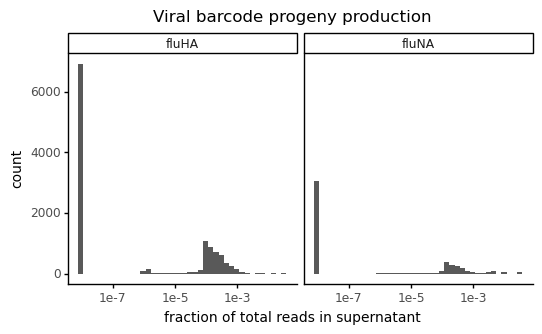

<ggplot: (8780815313791)>

In [35]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=40) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_color_brewer(type='qual', palette=3))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


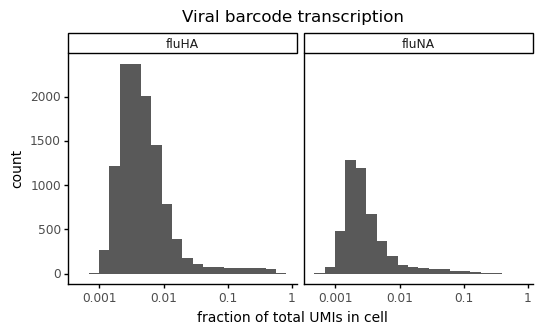

<ggplot: (8780814967104)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs,
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_brewer(type='qual', palette=3))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


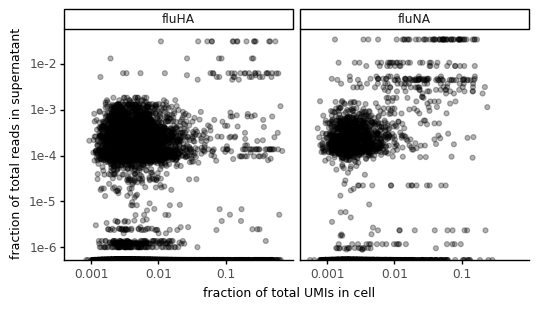

<ggplot: (8780814797635)>

In [36]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
#        p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_brewer(type='qual', palette=3))
display(fig)

In [42]:
# limit_percentile = 0.95

# high_productive_limit = {}
# for gene in barcoded_viral_genes:
#     limit = (viral_bc_freqs
#              .query(f'(gene == "{gene}")')
#              ['freq_progeny']
#              .quantile(limit_percentile))
#     high_productive_limit[f'{gene}'] = limit
#     print(f'The limit for a viral barcode on {gene} is {limit:.5f}.')

# # Convert to DataFrame for plotting
# high_productive_limit = (pd.DataFrame.from_dict(high_productive_limit,
#                                                 orient='index',
#                                                 columns=['limit'])
#                          .reset_index()
#                          .rename(columns={'index': 'gene'}))

The limit for a viral barcode on fluHA is 0.00089.
The limit for a viral barcode on fluNA is 0.00895.


In [43]:
# viral_bc_freqs = pd.merge(left=viral_bc_freqs,
#                          right=high_productive_limit,
#                          on='gene',
#                          how='outer',
#                          validate='many_to_one')
# viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,freq_progeny,present_in_supernatant_tags,limit
0,AAACCCAAGTAGGTTA,True,syn,fluHA,AGAATCGACACATGTC,0.002609,NaN,NaN,0.000892
1,GTAGGTTTCGTTTACT,True,syn,fluHA,AGAATCGACACATGTC,0.002756,NaN,NaN,0.000892
2,AAACCCAAGTAGGTTA,True,syn,fluHA,CACGGATGGTGTACGA,0.002236,NaN,NaN,0.000892
3,AAACCCAAGTAGGTTA,True,syn,fluHA,CTTAACTGTATATTCG,0.004844,0.000981,syn and wt,0.000892
4,AAAGTCCAGGATTTAG,True,syn,fluHA,CTTAACTGTATATTCG,0.003273,0.000981,syn and wt,0.000892
...,...,...,...,...,...,...,...,...,...
16274,TTTGGAGGTATGGAGC,True,syn,fluNA,GTAATACATGCAGTTG,0.002772,0.000149,syn,0.008954
16275,TTTGGAGGTTCGCGTG,True,wt,fluNA,CCGGTATGCGAGGTGG,0.006227,NaN,NaN,0.008954
16276,TTTGGTTCATCTGCGG,True,both,fluNA,TTGTATAAAAATACAG,0.007323,NaN,NaN,0.008954
16277,TTTGGTTGTCGGTGTC,True,syn,fluNA,AATAAGCGGCTCTTTG,0.003318,NaN,NaN,0.008954


In [59]:
viral_bc_freqs['high_progeny'] = (viral_bc_freqs['freq_progeny'] >= 5e-3)

False    16120
True       159
Name: high_progeny, dtype: int64

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


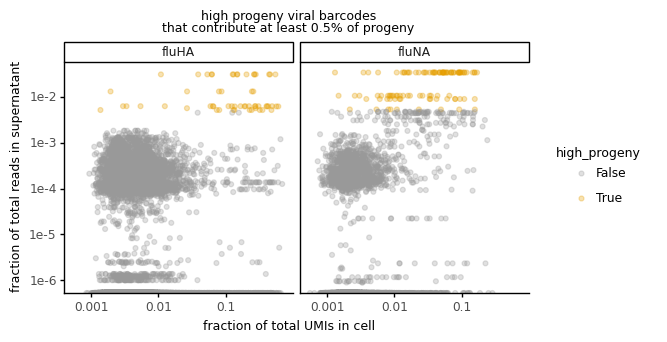

<ggplot: (8780815010446)>

In [60]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='high_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle('high progeny viral barcodes\n'
                  'that contribute at least 0.5% of progeny') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)

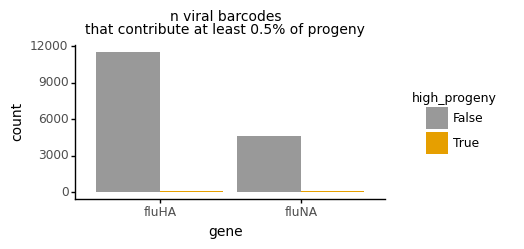

<ggplot: (8780814764605)>

In [77]:
fig = (p9.ggplot(viral_bc_freqs,
                 p9.aes(x='gene',
                        fill='cell_barcode')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('n viral barcodes\n'
                  'that contribute at least 0.5% of progeny') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

In [83]:
viral_bc_freqs.query('high_progeny == True')['cell_barcode'].nunique()

156

# Later
Annotate presence of each viral barcode in infecting viral tags in transcriptome data:

In [13]:
test = pd.merge(
    left=viral_bc_freqs,
    right=viral_bc_freqs.groupby(['viral_barcode','gene'])['infecting_viral_tag'].unique().apply(list).apply(str),
    on=['viral_barcode',
        'gene'],
    suffixes=['','_present'])
display(test)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,freq_progeny,present_in_supernatant_tags,infecting_viral_tag_present
0,AAACCCAAGTAGGTTA,True,syn,fluHA,AGAATCGACACATGTC,0.002609,NaN,NaN,"['syn', 'both']"
1,GTAGGTTTCGTTTACT,True,syn,fluHA,AGAATCGACACATGTC,0.002756,NaN,NaN,"['syn', 'both']"
2,GCTCAAACACGTGTGC,True,both,fluHA,AGAATCGACACATGTC,0.003453,NaN,NaN,"['syn', 'both']"
3,AAACCCAAGTAGGTTA,True,syn,fluHA,CACGGATGGTGTACGA,0.002236,NaN,NaN,['syn']
4,AAACCCAAGTAGGTTA,True,syn,fluHA,CTTAACTGTATATTCG,0.004844,0.000981,syn and wt,['syn']
...,...,...,...,...,...,...,...,...,...
16274,TTTGGAGGTATGGAGC,True,syn,fluNA,GAGTGTACTTGGCGTC,0.003465,NaN,NaN,['syn']
16275,TTTGGAGGTATGGAGC,True,syn,fluNA,GTAATACATGCAGTTG,0.002772,0.000149,syn,['syn']
16276,TTTGGAGGTTCGCGTG,True,wt,fluNA,CCGGTATGCGAGGTGG,0.006227,NaN,NaN,['wt']
16277,TTTGGTTGTCGGTGTC,True,syn,fluNA,AATAAGCGGCTCTTTG,0.003318,NaN,NaN,['syn']


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 10000 rows containing missing values.


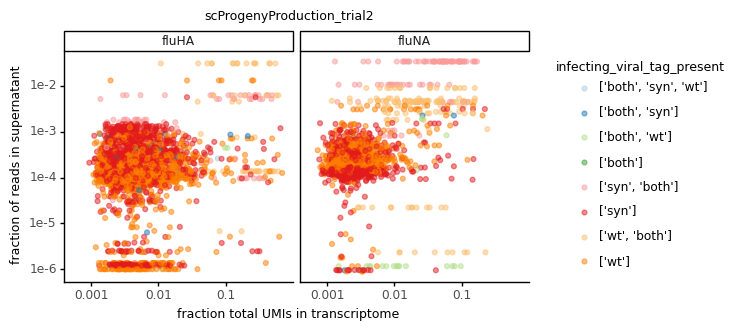

<ggplot: (8780838409385)>

In [14]:
fig = (p9.ggplot(test,
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag_present')) +
       p9.geom_point(alpha=0.5) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction total UMIs in transcriptome',
               y='fraction of reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_brewer(type='qual', palette=3))
display(fig)